In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import dask
import scipy
import glob
from tqdm import tqdm
from datetime import datetime, timedelta
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import os
import skimage

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import Stamen
from cartopy.io.img_tiles import MapboxTiles
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings("ignore")

import imageio
import geojson
import requests

from launches import *
from utils import *

from scipy.optimize import curve_fit
import matplotlib as mpl
from matplotlib import font_manager as fm

%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /home/jpalmo/.conda/envs/earthdata/share/proj failed


In [2]:
# 1) Register your new fonts explicitly
font_dir = os.path.expanduser("~/.local/share/fonts")
for path in glob.glob(os.path.join(font_dir, "lm*.otf")):
    fm.fontManager.addfont(path)
for path in glob.glob(os.path.join(font_dir, "cmu*.otf")):
    fm.fontManager.addfont(path)
# Global LaTeX-y defaults
mpl.rcParams.update({
    "text.usetex": False,              # keep mathtext (no TeX required)
    "mathtext.fontset": "cm",          # Computer Modern math
    "axes.unicode_minus": False,

    # Default family = serif (like LaTeX)
    "font.family": "serif",

    # Families mapped to your installed fonts (with sensible fallbacks)
    "font.serif": ["LMRoman10", "CMU Serif", "DejaVu Serif"],
    "font.sans-serif": ["LMSans10", "CMU Sans Serif", "DejaVu Sans"],
    "font.monospace": ["LMMono10", "CMU Typewriter Text", "DejaVu Sans Mono"],
})


### Load Data

In [3]:
initial_detections_df = pd.read_csv('data/initial_detections.csv',)
initial_detections_df['timestamp'] = pd.to_datetime(initial_detections_df['Launch_JD'], unit='D', origin='julian')

# Figure S3

In [4]:
# Open the dataset
geoscf_ds = load_geoscf()

In [5]:
pressure_levels_df = pd.read_csv("data/geos_pressure_levels.csv")

In [11]:
f9_emis_profile_df = pd.read_csv("data/Falcon9-traj-emissions.csv")
f9_emis_profile_df['pressure'] = pressure_levels_df['P(hPa)'].values[::-1]
# fuel burn from Cassandre paper, NOx EFs from NAS paper
f9_trop_emis_profile = f9_emis_profile_df[f9_emis_profile_df['pressure']>=100]


In [22]:
df = f9_trop_emis_profile

# Ensure pressure is highest at the bottom and strictly monotonic
if not (df['pressure'].is_monotonic_decreasing or df['pressure'].is_monotonic_increasing):
    df = df.sort_values('pressure', ascending=False)

# Convert hPa → Pa
p_mid = df['pressure'].to_numpy(dtype=float) * 100.0   # Pa, descending (≈ surface → top)

# Geometric-mean interior edges
p_edge_inner = np.sqrt(p_mid[:-1] * p_mid[1:])

# Extrapolated bottom/top edges using the end ratios
r = p_mid[1:] / p_mid[:-1]         # ratios between adjacent mids
p_bot = p_mid[0] / np.sqrt(r[0])   # edge just below the lowest (largest) mid-pressure
p_top = p_mid[-1] * np.sqrt(r[-1]) # edge just above the highest (smallest) mid-pressure

p_edges = np.concatenate(([p_bot], p_edge_inner, [p_top]))    # length = nlev+1

# Layer thicknesses
dp = p_edges[:-1] - p_edges[1:]             # Pa, positive
dlnp = np.log(p_edges[:-1] / p_edges[1:])   # unitless, positive


In [23]:
# Choose which columns are layer totals in kg (adjust names to yours)
kg_cols = ['Fuel-kg','CO2-kg','H2O-kg','BC-kg','NOX-kg']  # extend as needed

for col in kg_cols:
    df[f'{col}_perPa']   = df[col].to_numpy() / dp
    df[f'{col}_perlnp']  = df[col].to_numpy() / dlnp


In [24]:
from scipy.signal import savgol_filter

df = df.sort_values('pressure', ascending=False).reset_index(drop=True)

# Build log-pressure thicknesses (hPa→Pa)
p_mid = (df['pressure'].to_numpy(float) * 100.0)
p_edge_inner = np.sqrt(p_mid[:-1] * p_mid[1:])
r = p_mid[1:] / p_mid[:-1]
p_bot = p_mid[0] / np.sqrt(r[0])
p_top = p_mid[-1] * np.sqrt(r[-1])
p_edges = np.concatenate([[p_bot], p_edge_inner, [p_top]])
dlnp = np.log(p_edges[:-1] / p_edges[1:])

# Choose the column to plot
col = 'NOX-kg'                          # layer totals (kg)
perlnp = df[col].to_numpy() / dlnp      # kg per ln p

# ---- Option 1: centered rolling mean (3–7 levels) ----
roll = pd.Series(perlnp).rolling(window=9, center=True, min_periods=1).mean().to_numpy()

# ---- Option 2: Savitzky–Golay (preserves peaks) ----
# window_length must be odd and <= number of levels
win = min(len(df)//2*2-1,  nine:=9)     # e.g., 9 or the largest odd <= n-1
win = max(5, win)                        # keep it at least 5
savg = savgol_filter(perlnp, window_length=win, polyorder=2, mode='interp')

# Mass-conserve: scale smoothed density so ∑(dens*dlnp) = total mass
E_tot = df[col].sum()
roll_sm = roll * (E_tot / np.sum(roll * dlnp))
savg_sm = savg * (E_tot / np.sum(savg * dlnp))

# Store for plotting
df['NOX_perlnp']        = perlnp
df['NOX_perlnp_roll5']  = roll_sm
df['NOX_perlnp_savg09'] = savg_sm


In [25]:
launch = initial_detections_df.iloc[3]

In [26]:
# Get the GEOS-CF data for the launch location
lat = launch['lat']
lon = launch['lon']
time = launch['timestamp']

In [27]:
nearest = geoscf_ds.sel(lat=lat, lon=lon, time=time, method='nearest')

In [28]:
L = (nearest['no'] + nearest['no2']) / nearest['no2']

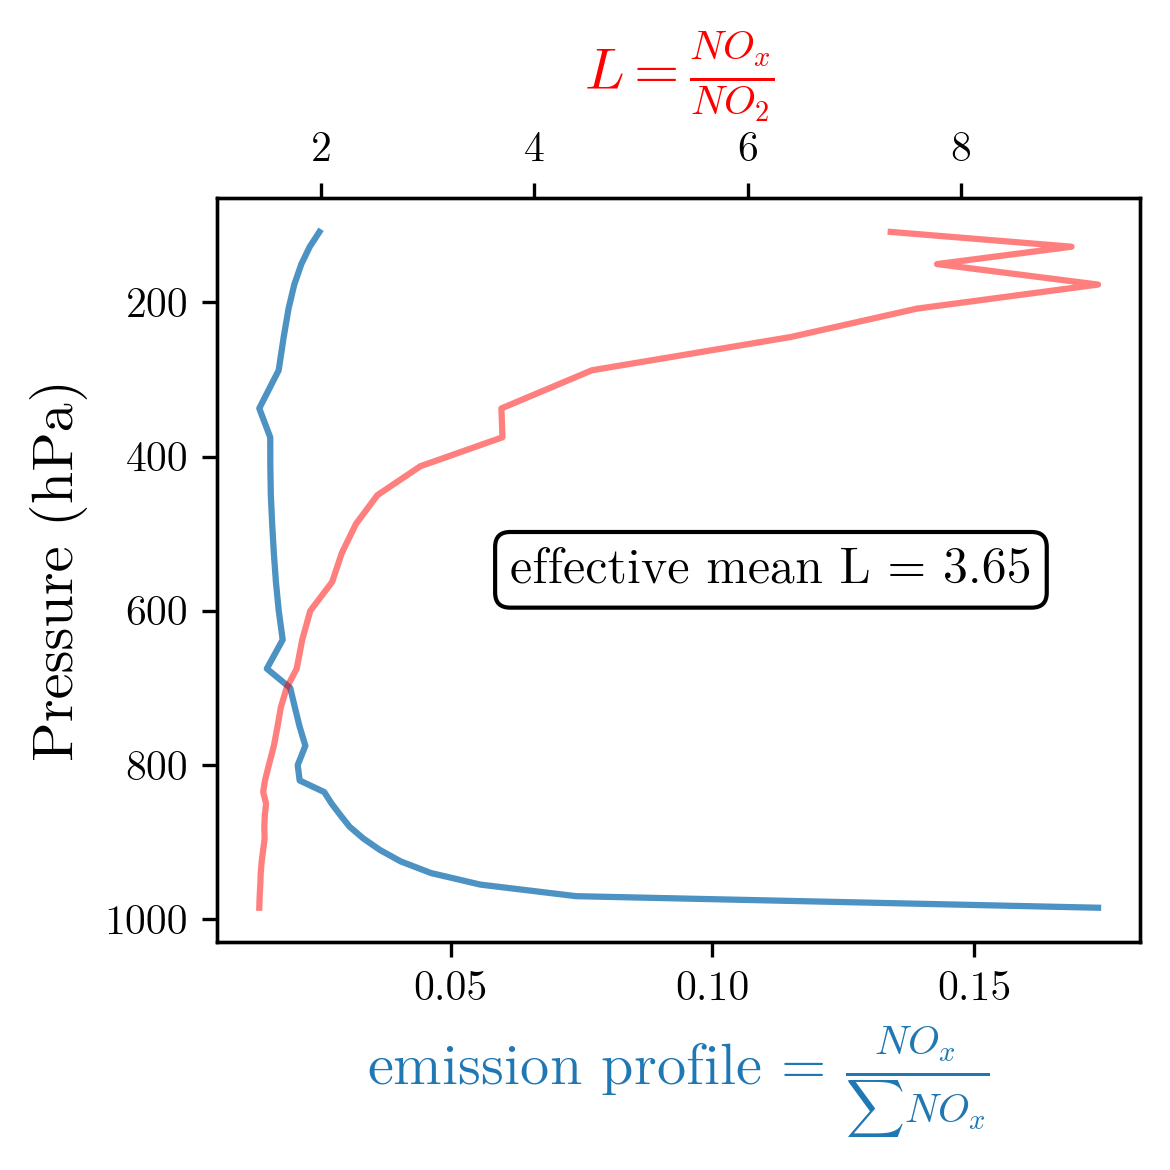

In [31]:
fig, ax = plt.subplots(figsize=(4,4), dpi=300)
# ax.plot((f9_trop_emis_profile['NOX-kg'] / f9_trop_emis_profile['NOX-kg'].sum()), f9_trop_emis_profile['pressure'],alpha=0.8, label="F9")
ax.plot((df['NOX-kg_perPa'] / df['NOX-kg_perPa'].sum()), df['pressure'], alpha=0.8, color='tab:blue', label="F9")
ax.set_xlabel(r"emission profile = $\frac{NO_x}{\sum{NO_x}}$", fontsize=14, color='tab:blue',)
ax.set_ylabel("Pressure (hPa)", fontsize=14)
#add another x-axis
ax2 = ax.twiny()

L.sel(lev=slice(100, 1000)).plot(y='lev', yincrease=False, ax=ax2, color='red', alpha=0.5)
ax2.set_xlabel(r"$L = \frac{NO_x}{NO_2}$", fontsize=14, labelpad=10, color='red',)
ax2.set_ylabel("Pressure (hPa)", fontsize=16)
ax2.set_title("")
# plt.suptitle("Falcon 9 Emission Profile and Level", fontsize=16, y=1.17)

ax.text(
    0.6, 0.5, f"effective mean L = {((f9_trop_emis_profile['NOX-kg'] / f9_trop_emis_profile['NOX-kg'].sum()) * L.sel(lev=slice(100, 1000))).sum():.2f}", ha='center', va='center', transform=ax.transAxes,
    fontsize=12, color='k', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
)

fig.tight_layout()
# save figure
plt.savefig(f'figures/supfig_3.png', dpi=300)

# Figure S4

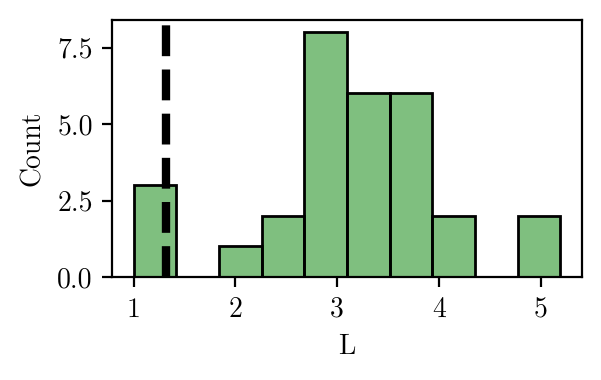

In [6]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=200)

sns.histplot(x=initial_detections_df['L'], kde=False, bins=10, log_scale=False, color='green', alpha=0.5)
# black vertical line at 1.32
plt.axvline(1.32, color='black', linestyle='--', linewidth=3)
# save figure
fig.tight_layout()
plt.savefig(f'figures/supfig_4.png', dpi=300)